In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('mycsv.csv')
df

,Date/Time,Date/Time (UTC),TOTAL WIND BASE SCHEDULE (FORECAST) IN BPA CONTROL AREA (MW; SCADA 187517,TOTAL WIND BASEPOINT (FORECAST) IN BPA CONTROL AREA (MW; SCADA 103349,TOTAL WIND GENERATION IN BPA CONTROL AREA (MW; SCADA 79687),TOTAL BPA CONTROL AREA LOAD (MW; SCADA 45583),TOTAL HYDRO GENERATION (MW; SCADA 79682),TOTAL FOSSIL/BIOMASS GENERATION (MW; SCADA 164377),TOTAL NUCLEAR GENERATION (MW; 70681),NET INTERCHANGE (MW; SCADA 45581),TOTAL SOLAR BASE SCHEDULE (FORECAST) IN BPA CONTROL AREA (MW; SCADA 187513),TOTAL SOLAR Basepoint (FORECAST) IN BPA CONTROL AREA (MW; SCADA 177165),TOTAL SOLAR GENERATION IN BPA CONTROL AREA (MW; SCADA 142383)
0,01-01-2022 00:00,01-01-2022 08:00,NaN,27.0,5.0,8320.0,10817.0,1096.0,1159.0,4757.0,NaN,0.0,0.0
1,01-01-2022 00:05,01-01-2022 08:05,NaN,24.0,5.0,8338.0,10960.0,1079.0,1165.0,4872.0,NaN,0.0,0.0
2,01-01-2022 00:10,01-01-2022 08:10,NaN,21.0,5.0,8337.0,11036.0,1056.0,1164.0,4925.0,NaN,0.0,0.0
3,01-01-2022 00:15,01-01-2022 08:15,NaN,21.0,6.0,8342.0,11084.0,1037.0,1165.0,4950.0,NaN,0.0,0.0
4,01-01-2022 00:20,01-01-2022 08:20,NaN,21.0,6.0,8354.0,11085.0,1032.0,1161.0,4930.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86383,10/27/22 23:35,10/28/22 06:35,579.0,701.0,670.0,5282.0,4361.0,1097.0,1152.0,1998.0,0.0,0.0,0.0
86384,10/27/22 23:40,10/28/22 06:40,579.0,686.0,678.0,5244.0,4332.0,1095.0,1149.0,2013.0,0.0,0.0,0.0
86385,10/27/22 23:45,10/28/22 06:45,579.0,678.0,680.0,5223.0,4366.0,1096.0,1149.0,2068.0,0.0,0.0,0.0
86386,10/27/22 23:50,10/28/22 06:50,579.0,681.0,687.0,5216.0,4351.0,1097.0,1149.0,2069.0,0.0,0.0,0.0


In [3]:
df1 = df[['Date/Time', 'TOTAL WIND GENERATION  IN BPA CONTROL AREA (MW; SCADA 79687)']]
df1.rename(columns={'TOTAL WIND GENERATION  IN BPA CONTROL AREA (MW; SCADA 79687)': 'WindPower'}, inplace=True)
df1.set_index('Date/Time', inplace=True)
df1

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14592\1315962383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'TOTAL WIND GENERATION  IN BPA CONTROL AREA (MW; SCADA 79687)': 'WindPower'}, inplace=True)


,WindPower
Date/Time,
01-01-2022 00:00,5.0
01-01-2022 00:05,5.0
01-01-2022 00:10,5.0
01-01-2022 00:15,6.0
01-01-2022 00:20,6.0
...,...
10/27/22 23:35,670.0
10/27/22 23:40,678.0
10/27/22 23:45,680.0


In [4]:
df1.dtypes

WindPower    float64
dtype: object

In [5]:
df1.isnull().sum()

WindPower    12
dtype: int64

In [6]:
mean_wind_power = df1['WindPower'].mean()

df1['WindPower'].fillna(mean_wind_power, inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14592\4027946816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['WindPower'].fillna(mean_wind_power, inplace=True)


In [7]:
df1.isnull().sum()

WindPower    0
dtype: int64

In [8]:
df_new = df1.describe().transpose()
df_new

,count,mean,std,min,25%,50%,75%,max
WindPower,86388.0,732.712744,757.830476,0.0,81.0,423.0,1270.0,2641.0


In [9]:
# Convert the 'WindPower' column to a numeric type, coercing any errors to NaN
wind_generation_numeric = pd.to_numeric(df1['WindPower'], errors='coerce')

# Drop any NaN values that resulted from the conversion
wind_generation_numeric.dropna(inplace=True)

mean_wind_gen = 732.712744
std_wind_gen = 757.830476


z_scores = (wind_generation_numeric - mean_wind_gen) / std_wind_gen

z_score_threshold = 3

# Identify outliers
outliers = z_scores[np.abs(z_scores) > z_score_threshold]

outlier_summary = {
    "mean": mean_wind_gen,
    "std_dev": std_wind_gen,
    "threshold": z_score_threshold,
    "number_of_outliers": outliers.count(),
    "outlier_indices": outliers.index.tolist(),
    "outlier_values": outliers.tolist()
}

outlier_summary


{'mean': 732.712744,
 'std_dev': 757.830476,
 'threshold': 3,
 'number_of_outliers': 0,
 'outlier_indices': [],
 'outlier_values': []}

In [10]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        # Extract a window of data with 'window_size' time steps
        window = df_as_np[i:i+window_size]

        # Append the window to X
        X.append(window)

        # Extract the label (next data point after the window)
        label = df_as_np[i+window_size]

        # Append the label to y
        y.append(label)

    # Convert X and y to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

In [11]:
WINDOW_SIZE = 12
X1, y1 = df_to_X_y(df1, WINDOW_SIZE)
X1.shape, y1.shape

((86376, 12, 1), (86376, 1))

In [12]:
length = len(df)

# Convert to integers
train_length = int(0.7 * length)
val_length = int(0.85 * length)

X_train1, y_train1 = X1[:train_length], y1[:train_length]
X_val1, y_val1 = X1[train_length:val_length], y1[train_length:val_length]
X_test1, y_test1 = X1[val_length:], y1[val_length:]

# Check the shapes
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)


(60471, 12, 1) (60471, 1) (12958, 12, 1) (12958, 1) (12947, 12, 1) (12947, 1)


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape and flatten X_train1, X_val1, X_test1
X_train1_reshaped = X_train1.reshape(-1, X_train1.shape[-1])
X_val1_reshaped = X_val1.reshape(-1, X_val1.shape[-1])
X_test1_reshaped = X_test1.reshape(-1, X_test1.shape[-1])

# Fit and transform the scalers on the training data
X_train1_normalized = scaler_X.fit_transform(X_train1_reshaped)
y_train1_normalized = scaler_y.fit_transform(y_train1.reshape(-1, 1))

# Reshape the normalized data back to the original shape
X_train1_normalized = X_train1_normalized.reshape(X_train1.shape)
y_train1_normalized = y_train1_normalized.reshape(y_train1.shape)

# Transform the validation and test data using the fitted scalers
X_val1_normalized = scaler_X.transform(X_val1_reshaped)
X_test1_normalized = scaler_X.transform(X_test1_reshaped)

# Reshape the normalized data back to the original shape for validation and test
X_val1_normalized = X_val1_normalized.reshape(X_val1.shape)
X_test1_normalized = X_test1_normalized.reshape(X_test1.shape)

y_val1_normalized = scaler_y.transform(y_val1.reshape(-1, 1))


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((X1.shape[1],1)))
model1.add(LSTM(64,'relu'))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 64)                16896     
                                                                 
 dense_57 (Dense)            (None, 8)                 520       
                                                                 
 dense_58 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [34]:
cp1 = ModelCheckpoint('model1/')
model1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
)

In [35]:
history = model1.fit(X_train1_normalized, y_train1_normalized, validation_data=(X_val1_normalized, y_val1_normalized), epochs=100)


Epoch 1/100
1890/1890 [==============================] - 10s 5ms/step - loss: 2.6139e-04 - root_mean_squared_error: 0.0162 - mean_absolute_error: 0.0094 - val_loss: 1.4148e-04 - val_root_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0070
Epoch 2/100
1890/1890 [==============================] - 10s 5ms/step - loss: 2.2585e-04 - root_mean_squared_error: 0.0150 - mean_absolute_error: 0.0086 - val_loss: 1.3335e-04 - val_root_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0073
Epoch 3/100
1890/1890 [==============================] - 10s 5ms/step - loss: 1.9425e-04 - root_mean_squared_error: 0.0139 - mean_absolute_error: 0.0079 - val_loss: 1.1252e-04 - val_root_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0066
Epoch 4/100
1890/1890 [==============================] - 10s 5ms/step - loss: 1.6991e-04 - root_mean_squared_error: 0.0130 - mean_absolute_error: 0.0074 - val_loss: 8.6874e-05 - val_root_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0054
Epoch 5/

Epoch 34/100
1890/1890 [==============================] - 10s 5ms/step - loss: 9.9076e-05 - root_mean_squared_error: 0.0100 - mean_absolute_error: 0.0052 - val_loss: 4.9373e-05 - val_root_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0041
Epoch 35/100
1890/1890 [==============================] - 10s 5ms/step - loss: 9.9071e-05 - root_mean_squared_error: 0.0100 - mean_absolute_error: 0.0052 - val_loss: 5.2618e-05 - val_root_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0046
Epoch 36/100
1890/1890 [==============================] - 10s 5ms/step - loss: 9.9867e-05 - root_mean_squared_error: 0.0100 - mean_absolute_error: 0.0052 - val_loss: 4.8298e-05 - val_root_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0040
Epoch 37/100
1890/1890 [==============================] - 10s 6ms/step - loss: 9.7933e-05 - root_mean_squared_error: 0.0099 - mean_absolute_error: 0.0051 - val_loss: 5.9525e-05 - val_root_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0053
Epoc

Epoch 67/100
1890/1890 [==============================] - 10s 6ms/step - loss: 9.5726e-05 - root_mean_squared_error: 0.0098 - mean_absolute_error: 0.0050 - val_loss: 4.8088e-05 - val_root_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0040
Epoch 68/100
1890/1890 [==============================] - 10s 5ms/step - loss: 9.4867e-05 - root_mean_squared_error: 0.0097 - mean_absolute_error: 0.0049 - val_loss: 4.7907e-05 - val_root_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0040
Epoch 69/100
1890/1890 [==============================] - 11s 6ms/step - loss: 9.5273e-05 - root_mean_squared_error: 0.0098 - mean_absolute_error: 0.0050 - val_loss: 4.9635e-05 - val_root_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0042
Epoch 70/100
1890/1890 [==============================] - 10s 6ms/step - loss: 9.5144e-05 - root_mean_squared_error: 0.0098 - mean_absolute_error: 0.0050 - val_loss: 5.2542e-05 - val_root_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0046
Epoc

Epoch 100/100
1890/1890 [==============================] - 10s 6ms/step - loss: 9.2415e-05 - root_mean_squared_error: 0.0096 - mean_absolute_error: 0.0049 - val_loss: 5.0070e-05 - val_root_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0043


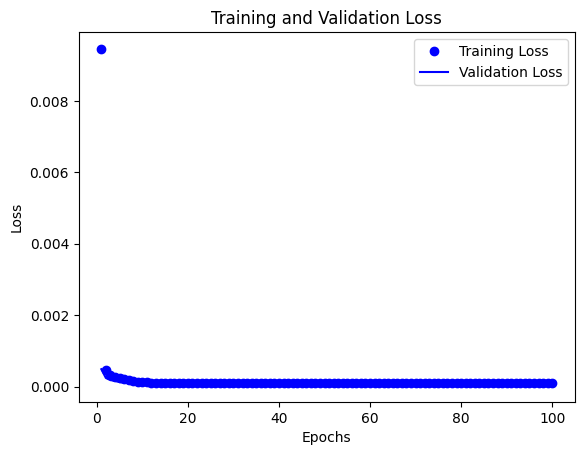

In [16]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epoch numbers
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
validation_results = model1.evaluate(X_val1_normalized, y_val1_normalized)


405/405 [==============================] - 1s 2ms/step - loss: 4.8286e-05 - root_mean_squared_error: 0.0069 - mean_absolute_error: 0.0041 - mean_absolute_percentage_error: 788.6568


In [20]:
pip install tensorflow scikit-learn scikit-optimize


                                              0.0/100.3 kB ? eta -:--:--
     -----------                           30.7/100.3 kB 640.0 kB/s eta 0:00:01
     ----------------------                61.4/100.3 kB 648.1 kB/s eta 0:00:01
     ------------------------------------ 100.3/100.3 kB 720.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the model creation function
def create_model(num_layers, num_neurons, activation_function):
    model = Sequential()
    model.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Only the last layer doesn't return sequences
        model.add(LSTM(units=num_neurons, activation=activation_function, return_sequences=return_sequences))
    model.add(Dense(1, activation='linear'))  # Output layer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Wrap the model in KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

# Define the parameter grid
param_grid = {
    'num_layers': [1, 2, 3],  # Number of LSTM layers
    'num_neurons': [32, 64, 128],  # Number of neurons in each layer
    'activation_function': ['relu', 'tanh']  # Activation functions
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit GridSearchCV to the training data
grid_result = grid.fit(X_train1_normalized, y_train1_normalized)

# Best parameters
best_parameters = grid_result.best_params_
print("Best Parameters: ", best_parameters)


Epoch 1/10


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14592\3714253050.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=1)


1260/1260 [==============================] - 4s 2ms/step - loss: 0.0035
Epoch 2/10
1260/1260 [==============================] - 3s 3ms/step - loss: 2.5656e-04
Epoch 3/10
1260/1260 [==============================] - 3s 3ms/step - loss: 1.8699e-04
Epoch 4/10
1260/1260 [==============================] - 3s 3ms/step - loss: 1.4836e-04
Epoch 5/10
1260/1260 [==============================] - 3s 3ms/step - loss: 1.3551e-04
Epoch 6/10
1260/1260 [==============================] - 3s 2ms/step - loss: 1.2735e-04
Epoch 7/10
1260/1260 [==============================] - 3s 2ms/step - loss: 1.2239e-04
Epoch 8/10
1260/1260 [==============================] - 3s 2ms/step - loss: 1.1929e-04
Epoch 9/10
1260/1260 [==============================] - 3s 2ms/step - loss: 1.1748e-04
Epoch 10/10
630/630 [==============================] - 1s 1ms/step - loss: 9.2278e-05
Epoch 1/10
1260/1260 [==============================] - 4s 2ms/step - loss: 0.0019
Epoch 2/10
1260/1260 [==============================] - 3s 2ms/

1260/1260 [==============================] - 7s 6ms/step - loss: 9.4579e-05
Epoch 9/10
1260/1260 [==============================] - 7s 6ms/step - loss: 9.2563e-05
Epoch 10/10
630/630 [==============================] - 2s 2ms/step - loss: 1.3737e-04
Epoch 1/10
1260/1260 [==============================] - 9s 6ms/step - loss: 0.0032
Epoch 2/10
1260/1260 [==============================] - 7s 6ms/step - loss: 4.0560e-04
Epoch 3/10
1260/1260 [==============================] - 7s 6ms/step - loss: 2.6184e-04
Epoch 4/10
1260/1260 [==============================] - 7s 6ms/step - loss: 1.8713e-04
Epoch 5/10
1260/1260 [==============================] - 7s 6ms/step - loss: 1.5488e-04
Epoch 6/10
1260/1260 [==============================] - 7s 6ms/step - loss: 1.4164e-04
Epoch 7/10
1260/1260 [==============================] - 7s 6ms/step - loss: 1.3412e-04
Epoch 8/10
1260/1260 [==============================] - 7s 6ms/step - loss: 1.2995e-04
Epoch 9/10
1260/1260 [==============================] - 7s 

1260/1260 [==============================] - 29s 23ms/step - loss: 1.2034e-04
Epoch 5/10
1260/1260 [==============================] - 35s 28ms/step - loss: 1.1342e-04
Epoch 6/10
1260/1260 [==============================] - 36s 29ms/step - loss: 1.1012e-04
Epoch 7/10
1260/1260 [==============================] - 45s 36ms/step - loss: 1.0671e-04
Epoch 8/10
1260/1260 [==============================] - 49s 39ms/step - loss: 9.9670e-05
Epoch 9/10
1260/1260 [==============================] - 39s 31ms/step - loss: 9.9498e-05
Epoch 10/10
630/630 [==============================] - 7s 11ms/step - loss: 1.2971e-04
Epoch 1/10
1260/1260 [==============================] - 20s 13ms/step - loss: 0.0033
Epoch 2/10
1260/1260 [==============================] - 13s 10ms/step - loss: 5.1344e-04
Epoch 3/10
1260/1260 [==============================] - 11s 9ms/step - loss: 3.2366e-04
Epoch 4/10
1260/1260 [==============================] - 11s 9ms/step - loss: 2.0983e-04
Epoch 5/10
1260/1260 [==================

1260/1260 [==============================] - 42s 33ms/step - loss: 1.2989e-04
Epoch 10/10
630/630 [==============================] - 6s 10ms/step - loss: 8.1445e-05
Epoch 1/10
1260/1260 [==============================] - 53s 41ms/step - loss: 0.0025
Epoch 2/10
1260/1260 [==============================] - 51s 41ms/step - loss: 3.0866e-04
Epoch 3/10
1260/1260 [==============================] - 52s 41ms/step - loss: 1.6239e-04
Epoch 4/10
1260/1260 [==============================] - 53s 42ms/step - loss: 1.3285e-04
Epoch 5/10
1260/1260 [==============================] - 51s 41ms/step - loss: 1.3133e-04
Epoch 6/10
1260/1260 [==============================] - 51s 41ms/step - loss: 1.3501e-04
Epoch 7/10
1260/1260 [==============================] - 51s 41ms/step - loss: 1.2060e-04
Epoch 8/10
1260/1260 [==============================] - 51s 41ms/step - loss: 1.0512e-04
Epoch 9/10
1260/1260 [==============================] - 52s 41ms/step - loss: 1.0958e-04
Epoch 10/10
630/630 [=================

1260/1260 [==============================] - 23s 18ms/step - loss: 1.1413e-04
Epoch 6/10
1260/1260 [==============================] - 23s 18ms/step - loss: 1.1416e-04
Epoch 7/10
1260/1260 [==============================] - 23s 18ms/step - loss: 1.1112e-04
Epoch 8/10
1260/1260 [==============================] - 24s 19ms/step - loss: 1.0852e-04
Epoch 9/10
1260/1260 [==============================] - 24s 19ms/step - loss: 1.0961e-04
Epoch 10/10
630/630 [==============================] - 3s 5ms/step - loss: 9.5500e-05
Epoch 1/10
1260/1260 [==============================] - 24s 18ms/step - loss: 7.5277e-04
Epoch 2/10
1260/1260 [==============================] - 23s 18ms/step - loss: 2.0400e-04
Epoch 3/10
1260/1260 [==============================] - 23s 18ms/step - loss: 1.4214e-04
Epoch 4/10
1260/1260 [==============================] - 23s 18ms/step - loss: 1.0683e-04
Epoch 5/10
1260/1260 [==============================] - 23s 18ms/step - loss: 9.8358e-05
Epoch 6/10
1260/1260 [=============

630/630 [==============================] - 7s 10ms/step - loss: 1.1586e-04
Epoch 1/10
1260/1260 [==============================] - 57s 44ms/step - loss: 9.0870e-04
Epoch 2/10
1260/1260 [==============================] - 55s 43ms/step - loss: 2.0473e-04
Epoch 3/10
1260/1260 [==============================] - 57s 45ms/step - loss: 1.3900e-04
Epoch 4/10
1260/1260 [==============================] - 57s 46ms/step - loss: 1.2606e-04
Epoch 5/10
1260/1260 [==============================] - 58s 46ms/step - loss: 1.2680e-04
Epoch 6/10
1260/1260 [==============================] - 57s 45ms/step - loss: 1.2617e-04
Epoch 7/10
1260/1260 [==============================] - 59s 47ms/step - loss: 1.2074e-04
Epoch 8/10
1260/1260 [==============================] - 58s 46ms/step - loss: 1.1900e-04
Epoch 9/10
1260/1260 [==============================] - 60s 48ms/step - loss: 1.1876e-04
Epoch 10/10
630/630 [==============================] - 8s 12ms/step - loss: 2.2178e-04
Epoch 1/10
1260/1260 [===============

1260/1260 [==============================] - 88s 70ms/step - loss: 1.3591e-04
Epoch 6/10
1260/1260 [==============================] - 87s 69ms/step - loss: 1.3079e-04
Epoch 7/10
1260/1260 [==============================] - 87s 69ms/step - loss: 1.3330e-04
Epoch 8/10
1260/1260 [==============================] - 87s 69ms/step - loss: 1.2603e-04
Epoch 9/10
1260/1260 [==============================] - 90s 72ms/step - loss: 1.2474e-04
Epoch 10/10
630/630 [==============================] - 11s 17ms/step - loss: 8.4211e-05
Epoch 1/10
1260/1260 [==============================] - 96s 74ms/step - loss: 0.0013
Epoch 2/10
1260/1260 [==============================] - 93s 74ms/step - loss: 2.2858e-04
Epoch 3/10
1260/1260 [==============================] - 93s 74ms/step - loss: 1.4212e-04
Epoch 4/10
1260/1260 [==============================] - 94s 75ms/step - loss: 1.3433e-04
Epoch 5/10
1260/1260 [==============================] - 93s 74ms/step - loss: 1.3644e-04
Epoch 6/10
1260/1260 [===============

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model_ann = Sequential()
model_ann.add(InputLayer((X1.shape[1],)))  # Assuming X1.shape[1] is the input size
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dense(8, activation='relu'))
model_ann.add(Dense(1, activation='linear'))


model_ann.summary()

# Specify a valid checkpoint file path and extension
checkpoint_filepath = 'model_ann_checkpoint.h5'

cp2 = ModelCheckpoint(checkpoint_filepath)
model_ann.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]
)
history1 = model_ann.fit(X_train1_normalized, y_train1_normalized, validation_data=(X_val1_normalized, y_val1_normalized), epochs=100, callbacks=[cp2])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                832       
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1890/1890 [==============================] - 2s 970us/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - mean_absolute_error: 0.0189 - mean_absolute_percentage_error: 43027.4414 - val_loss: 1.8557e-04 - val_root_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0085 - val_mean_absolute_percen

Epoch 23/100
1890/1890 [==============================] - 2s 1ms/step - loss: 9.7282e-05 - root_mean_squared_error: 0.0099 - mean_absolute_error: 0.0050 - mean_absolute_percentage_error: 7476.9355 - val_loss: 5.0290e-05 - val_root_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0040 - val_mean_absolute_percentage_error: 154.5034
Epoch 24/100
1890/1890 [==============================] - 2s 1ms/step - loss: 9.7474e-05 - root_mean_squared_error: 0.0099 - mean_absolute_error: 0.0050 - mean_absolute_percentage_error: 6762.4878 - val_loss: 5.1854e-05 - val_root_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0042 - val_mean_absolute_percentage_error: 236.4961
Epoch 25/100
1890/1890 [==============================] - 2s 1ms/step - loss: 9.6865e-05 - root_mean_squared_error: 0.0098 - mean_absolute_error: 0.0050 - mean_absolute_percentage_error: 6933.0996 - val_loss: 4.9943e-05 - val_root_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0040 - val_mean_absolute_percentage

1890/1890 [==============================] - 2s 1ms/step - loss: 9.3224e-05 - root_mean_squared_error: 0.0097 - mean_absolute_error: 0.0049 - mean_absolute_percentage_error: 7104.0566 - val_loss: 5.5979e-05 - val_root_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0045 - val_mean_absolute_percentage_error: 558.9738
Epoch 72/100
1890/1890 [==============================] - 2s 1ms/step - loss: 9.2683e-05 - root_mean_squared_error: 0.0096 - mean_absolute_error: 0.0049 - mean_absolute_percentage_error: 5632.3804 - val_loss: 5.2087e-05 - val_root_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0042 - val_mean_absolute_percentage_error: 280.4010
Epoch 73/100
1890/1890 [==============================] - 2s 1ms/step - loss: 9.3775e-05 - root_mean_squared_error: 0.0097 - mean_absolute_error: 0.0049 - mean_absolute_percentage_error: 6369.8950 - val_loss: 4.9335e-05 - val_root_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0040 - val_mean_absolute_percentage_error: 183.4

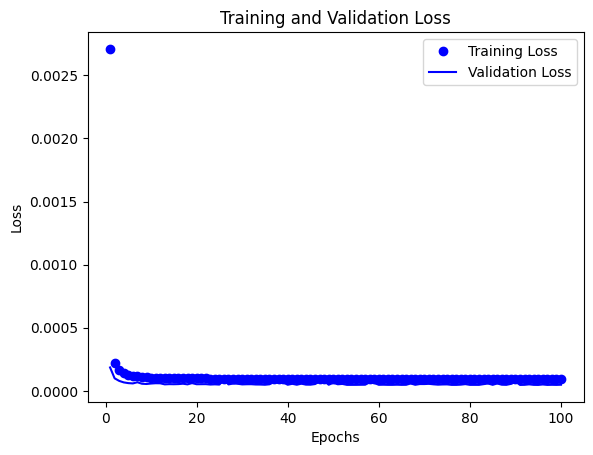

In [20]:
import matplotlib.pyplot as plt


loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Create an array of epoch numbers
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
validation_results = model_ann.evaluate(X_val1_normalized, y_val1_normalized)


405/405 [==============================] - 0s 712us/step - loss: 4.8870e-05 - root_mean_squared_error: 0.0070 - mean_absolute_error: 0.0040 - mean_absolute_percentage_error: 249.6029


405/405 [==============================] - 0s 537us/step


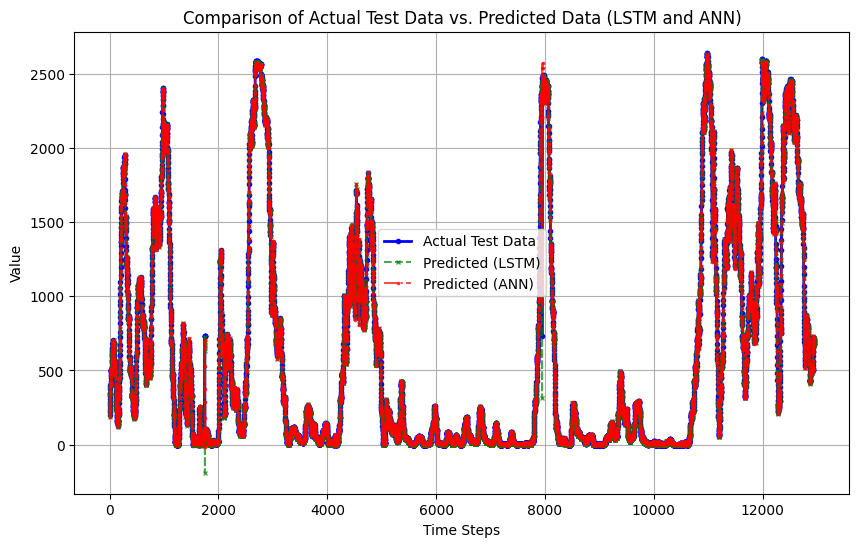

In [22]:
import matplotlib.pyplot as plt

# Make predictions on the test data for both models
y_test1_normalized_pred = model1.predict(X_test1_normalized)
y_test2_normalized_pred = model_ann.predict(X_test1_normalized)

# Inverse transform the predicted values to their original scale
y_test1_pred = scaler_y.inverse_transform(y_test1_normalized_pred)
y_test2_pred = scaler_y.inverse_transform(y_test2_normalized_pred)

# Create a single graph to compare the original test data with both predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test1, label='Actual Test Data', marker='o', markersize=3, linestyle='-', linewidth=2, color='blue')
plt.plot(y_test1_pred, label='Predicted (LSTM)', linestyle='--', marker='x', markersize=3, alpha=0.7, color='green')
plt.plot(y_test2_pred, label='Predicted (ANN)', linestyle='-.', marker='s', markersize=2, alpha=0.7, color='red')


plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Comparison of Actual Test Data vs. Predicted Data (LSTM and ANN)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Make predictions on the test data for both models
y_test1_normalized_pred = model1.predict(X_test1_normalized)
y_test2_normalized_pred = model_ann.predict(X_test1_normalized)

# Print the shapes of the predicted values
print("Shape of y_test1_normalized_pred:", y_test1_normalized_pred.shape)
print("Shape of y_test2_normalized_pred:", y_test2_normalized_pred.shape)


405/405 [==============================] - 0s 622us/step
Shape of y_test1_normalized_pred: (12947, 1)
Shape of y_test2_normalized_pred: (12947, 1)


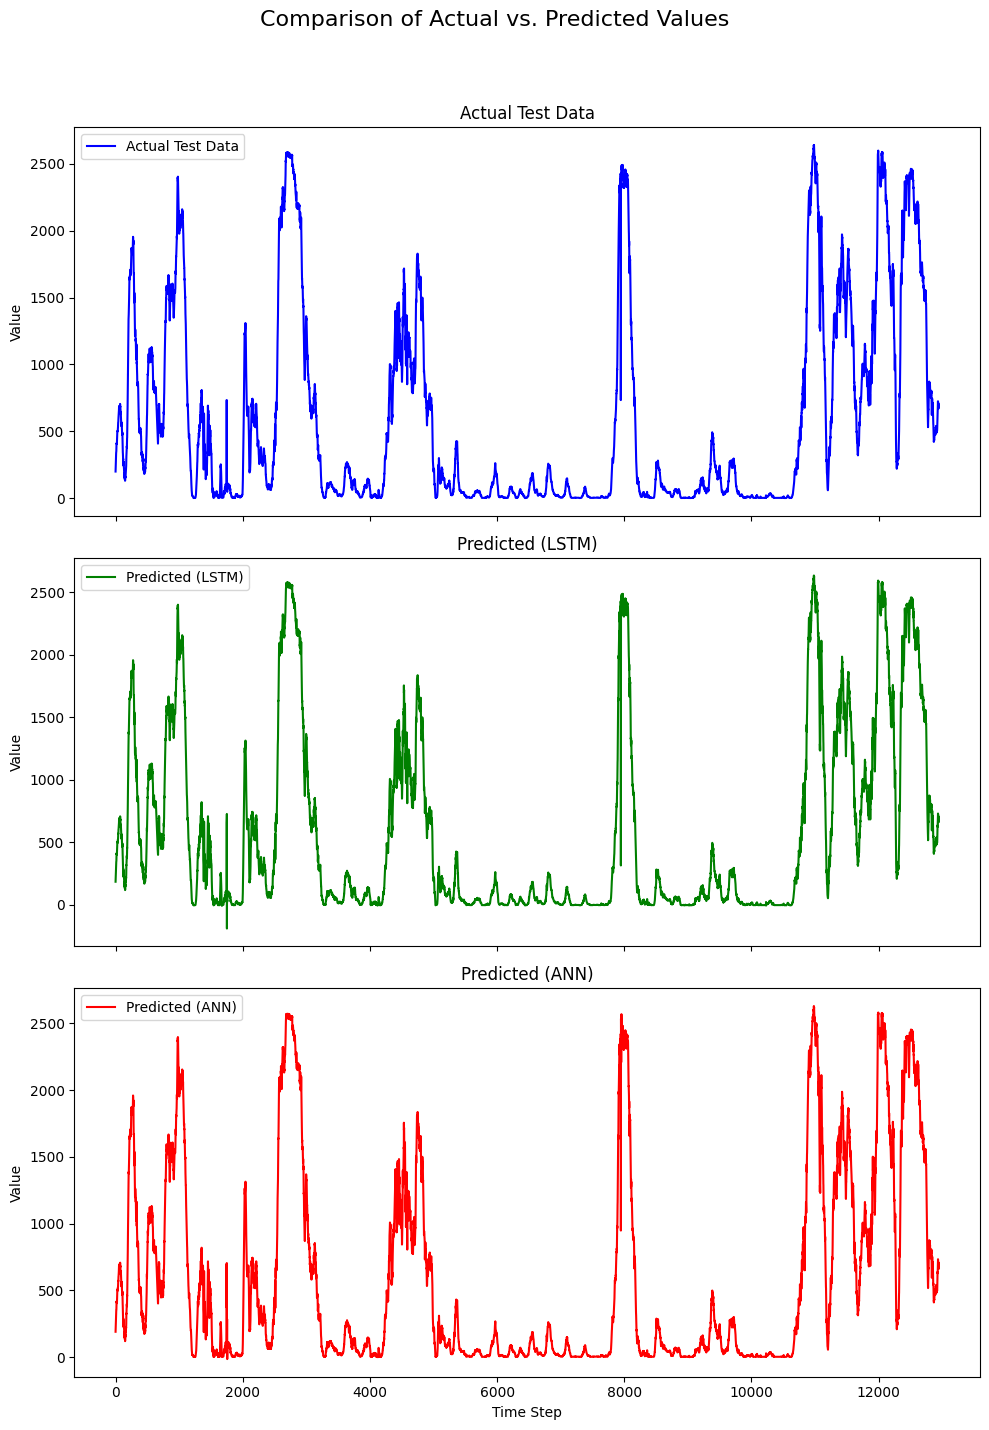

In [24]:
import matplotlib.pyplot as plt

# Assuming y_test1_pred and y_test2_pred are reshaped/flattened to 1D if needed
# y_test1_pred = y_test1_normalized_pred.flatten()
# y_test2_pred = y_test2_normalized_pred.flatten()

fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plotting the actual and predicted values in separate subplots
axs[0].plot(y_test1, label='Actual Test Data', color='blue')
axs[1].plot(y_test1_pred, label='Predicted (LSTM)', color='green')
axs[2].plot(y_test2_pred, label='Predicted (ANN)', color='red')

# Labeling each subplot
axs[0].set_title('Actual Test Data')
axs[1].set_title('Predicted (LSTM)')
axs[2].set_title('Predicted (ANN)')

# Adding labels and overall title
for ax in axs:
    ax.set_ylabel('Value')
    ax.legend()
axs[2].set_xlabel('Time Step')
fig.suptitle('Comparison of Actual vs. Predicted Values', fontsize=16)

# Displaying the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusts subplot params so that the subplot fits into the figure area
plt.show()


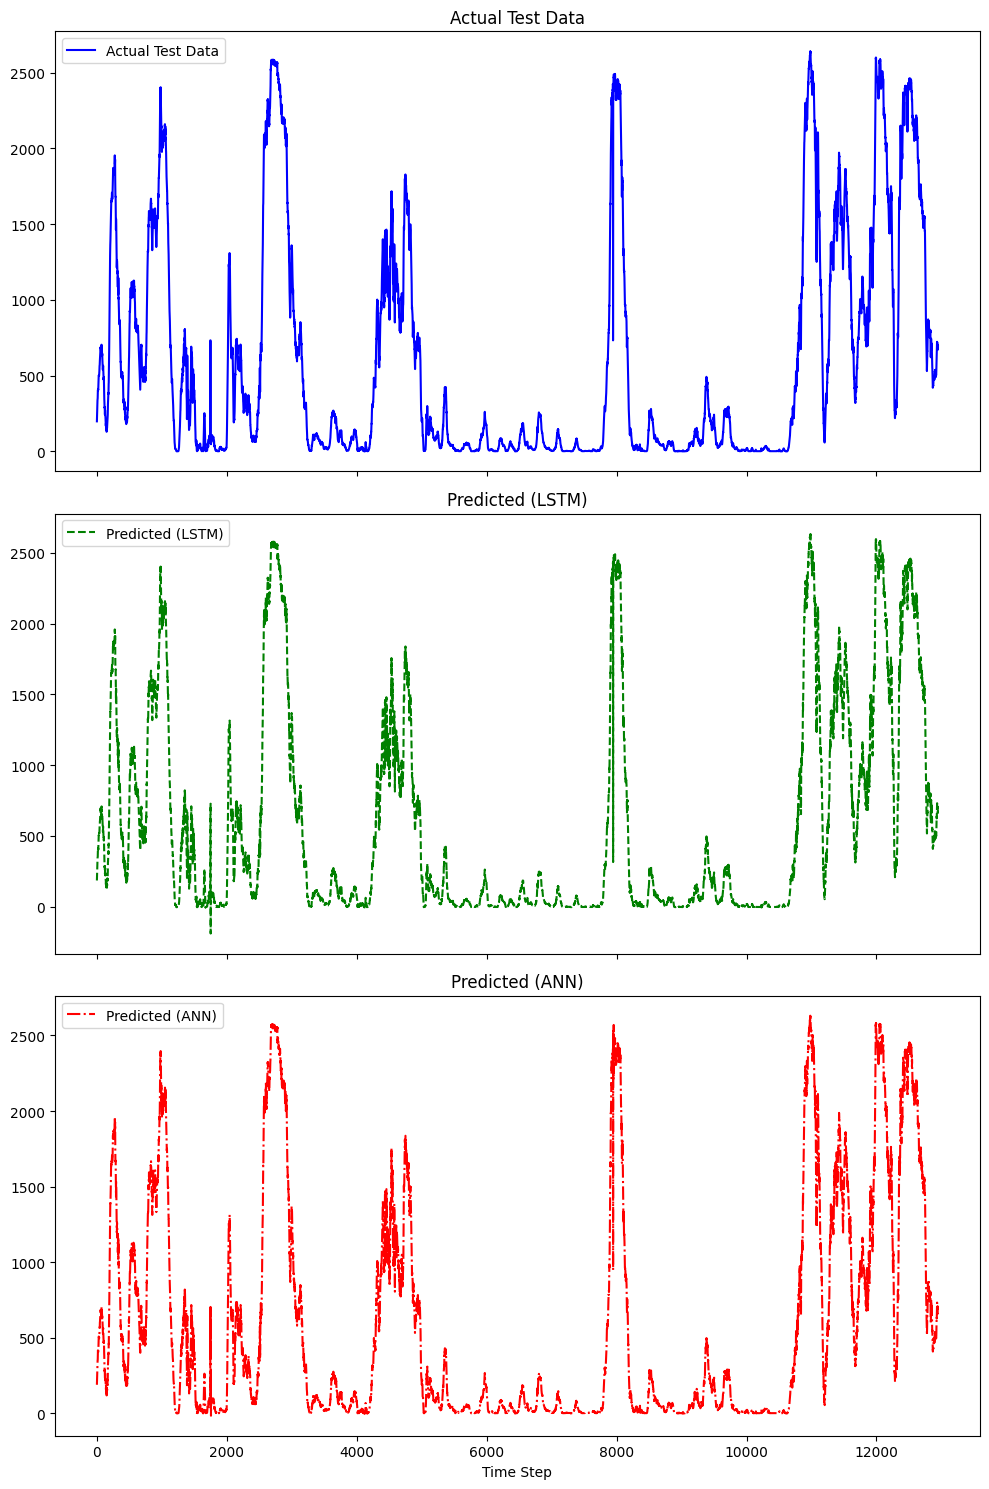

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plotting the actual test data on the first subplot
ax[0].plot(y_test1, label='Actual Test Data', color='blue')
ax[0].set_title('Actual Test Data')
ax[0].legend()

# Plotting the LSTM predictions on the second subplot
ax[1].plot(y_test1_pred, label='Predicted (LSTM)', linestyle='--', color='green')
ax[1].set_title('Predicted (LSTM)')
ax[1].legend()

# Plotting the ANN predictions on the third subplot
ax[2].plot(y_test2_pred, label='Predicted (ANN)', linestyle='-.', color='red')
ax[2].set_title('Predicted (ANN)')
ax[2].legend()

plt.xlabel('Time Step')
plt.tight_layout()
plt.show()
